# Imports

In [1]:
PROJECT_DIR = "/Users/pluz999/Documents/Oxford/Thesis/queue-value"

import sys
sys.path.append(PROJECT_DIR)

import matplotlib
import os

from datetime import datetime, time, timedelta
from collections import defaultdict
from tqdm import tqdm
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl

from scipy.sparse import csc_matrix, identity, linalg

from definitions import ROOT_DIR
from order_value.ImbalancePriceDeltaQueueOrderValue2 import ImbalancePriceDeltaQueueOrderValue2
from orderbook_aggregator.ImbalancePriceDeltaQueueAggregator2 import ImbalancePriceDeltaQueueAggregator2

# Set font

In [2]:
matplotlib.rc('font', family='Times New Roman') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

# Global variables

In [3]:
csco_ticker = "CSCO"
csco_levels = 5
csco_start_date = datetime(2019,1,1)
csco_end_date = datetime(2019,1,31)

bac_ticker = "BAC"
bac_levels = 10
bac_start_date = datetime(2019,11,1)
bac_end_date = datetime(2019,11,27)

# Load and process order book data

In [4]:
csco_orderbooks: List[ImbalancePriceDeltaQueueAggregator2] = []
for d in tqdm(pd.date_range(csco_start_date, csco_end_date)):
    try:
        csco_orderbooks.append(ImbalancePriceDeltaQueueAggregator2(d, csco_ticker, csco_levels, spread_size=100))
    except FileNotFoundError:
        continue

100%|██████████| 31/31 [38:45<00:00, 75.02s/it]  


In [5]:
bac_orderbooks: List[ImbalancePriceDeltaQueueAggregator2] = []
for d in tqdm(pd.date_range(bac_start_date, bac_end_date)):
    try:
        bac_orderbooks.append(
            ImbalancePriceDeltaQueueAggregator2(
                d, bac_ticker, bac_levels, spread_size=100, queue_position_step_size=2_000, max_queue_position = 20_000
            )
        )
    except FileNotFoundError:
        continue

100%|██████████| 27/27 [14:23<00:00, 31.97s/it]


# Order book analysis

In [6]:
bac_orderbooks[0].orderbook.head().drop(
    columns=[
        "ask_price_0", "ask_size_0", "bid_price_0", "bid_size_0", "bid_price_1", "bid_size_1", 
        "next_imbalance", "prev_mid_move", "next_mid_price_delta", "next_spread", "next_ask_spread"
    ]
)

,ask_price_1,ask_size_1,imbalance,spread,ask_spread,mid_price,mid_price_move,mid_price_delta,limit_sell,cancel_sell
datetime,,,,,,,,,,
2019-11-01 09:45:01.300,314000,2815,0.75,100,100,313850.0,0.0,-0.0,0.0,0.0
2019-11-01 09:45:01.400,314000,2815,0.75,100,100,313850.0,0.0,-0.0,0.0,200.0
2019-11-01 09:45:01.500,314000,2615,0.75,100,100,313850.0,0.0,-0.0,0.0,0.0
2019-11-01 09:45:01.600,314000,2615,0.75,100,100,313850.0,0.0,-0.0,0.0,0.0
2019-11-01 09:45:01.700,314000,2615,0.75,100,100,313850.0,0.0,-0.0,0.0,0.0


In [7]:
non_clipped_orderbook = (
    bac_orderbooks[0].raw_orderbook.copy().drop_duplicates(["datetime"], keep="last").set_index("datetime")
)
non_clipped_orderbook = non_clipped_orderbook.reindex(bac_orderbooks[0].time_steps(), method="ffill")
non_clipped_orderbook["mid_price_move"] = (
    non_clipped_orderbook["mid_price"].shift(-1) - non_clipped_orderbook["mid_price"]
)
non_clipped_orderbook["mid_price_delta"] = bac_orderbooks[0]._calculate_raw_mid_price_delta(non_clipped_orderbook)

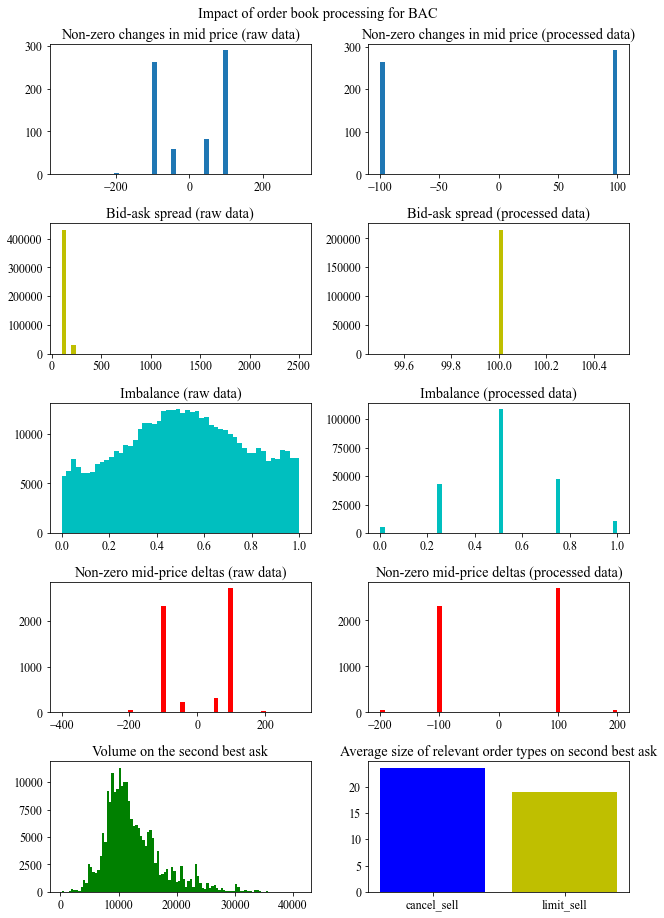

In [8]:
fig, ax = plt.subplots(5,2, figsize=(9,13))

ax[0,0].hist(non_clipped_orderbook[non_clipped_orderbook["mid_price_move"] != 0]["mid_price_move"] , bins=50)
ax[0,0].set_title("Non-zero changes in mid price (raw data)")

ax[0,1].hist(
    bac_orderbooks[0].orderbook[bac_orderbooks[0].orderbook["mid_price_move"] != 0]["mid_price_move"], bins=50
)
ax[0,1].set_title("Non-zero changes in mid price (processed data)")

ax[1,0].hist(bac_orderbooks[0].raw_orderbook["spread"], bins=50, color="y")
ax[1,0].set_title("Bid-ask spread (raw data)")

ax[1,1].hist(bac_orderbooks[0].orderbook["spread"], bins=50, color="y")
ax[1,1].set_title("Bid-ask spread (processed data)")

ax[2,0].hist(bac_orderbooks[0].raw_orderbook["imbalance"], bins=50, color="c")
ax[2,0].set_title("Imbalance (raw data)")

ax[2,1].hist(bac_orderbooks[0].orderbook["imbalance"], bins=50, color="c")
ax[2,1].set_title("Imbalance (processed data)")

ax[3,0].hist(
    non_clipped_orderbook[non_clipped_orderbook["mid_price_delta"] != 0]["mid_price_delta"], 
    bins=50, 
    color="r"
)
ax[3,0].set_title("Non-zero mid-price deltas (raw data)")

ax[3,1].hist(
    bac_orderbooks[0].orderbook[bac_orderbooks[0].orderbook["mid_price_delta"] != 0]["mid_price_delta"], 
    bins=50, 
    color="r"
)
ax[3,1].set_title("Non-zero mid-price deltas (processed data)")

ax[4,0].hist(bac_orderbooks[0].orderbook["ask_size_1"], bins=100, color="g")
ax[4,0].set_title("Volume on the second best ask")

my_colors = ['b', 'y', 'g', 'r']
ax[4,1].bar(
    ["cancel_sell", "limit_sell"],
    (
        bac_orderbooks[0].orderbook[["cancel_sell", "limit_sell"]].sum() / 
        len(bac_orderbooks[0].orderbook)
    ), 
    color=my_colors
)
ax[4,1].set_title("Average size of relevant order types on second best ask")

fig.suptitle("Impact of order book processing for BAC")
fig.tight_layout()
fig.subplots_adjust(top=0.94)

plt.show()

# Queue value analysis

### Determine Markov chain probabilities

In [9]:
csco_queue_value = ImbalancePriceDeltaQueueOrderValue2(csco_orderbooks)

100%|██████████| 20/20 [2:44:16<00:00, 492.81s/it]  


In [10]:
bac_queue_value = ImbalancePriceDeltaQueueOrderValue2(bac_orderbooks)

100%|██████████| 19/19 [1:30:44<00:00, 286.58s/it]


### Import "strategy 1" order values

In [11]:
csco_order_values_1 = pd.read_csv(
    os.path.join(ROOT_DIR, "models", "csco_order_value.csv"), index_col=[0,1,2]
).values.T[0]
csco_order_values_1 = np.append(csco_order_values_1, 0)

bac_order_values_1 = pd.read_csv(
    os.path.join(ROOT_DIR, "models", "bac_order_value.csv"), index_col=[0,1,2]
).values.T[0]
bac_order_values_1 = np.append(bac_order_values_1, 0)

### Investigate probabilities of state moves

In [12]:
csco_transient_sum = (
    identity(len(csco_queue_value.transient_prob_df.columns)).todense() * 0.9999 - 
    csco_queue_value.transient_prob_df.values
)
# * 0.9999 to ensure invertibility
csco_inv_trans_sum = pd.DataFrame(
    index=csco_queue_value.transient_prob_df.index,
    columns=csco_queue_value.transient_prob_df.columns,
    data=np.linalg.inv(csco_transient_sum)
).round(3)
csco_abs_delta_product = np.dot(csco_queue_value.absorbing_prob_df.values, csco_order_values_1)

bac_transient_sum = (
    identity(len(bac_queue_value.transient_prob_df.columns)).todense() - 
    bac_queue_value.transient_prob_df.values
)
bac_inv_trans_sum = pd.DataFrame(
    index=bac_queue_value.transient_prob_df.index,
    columns=bac_queue_value.transient_prob_df.columns,
    data=np.linalg.inv(bac_transient_sum)
).round(3)
bac_abs_delta_product = np.dot(bac_queue_value.absorbing_prob_df.values, bac_order_values_1)

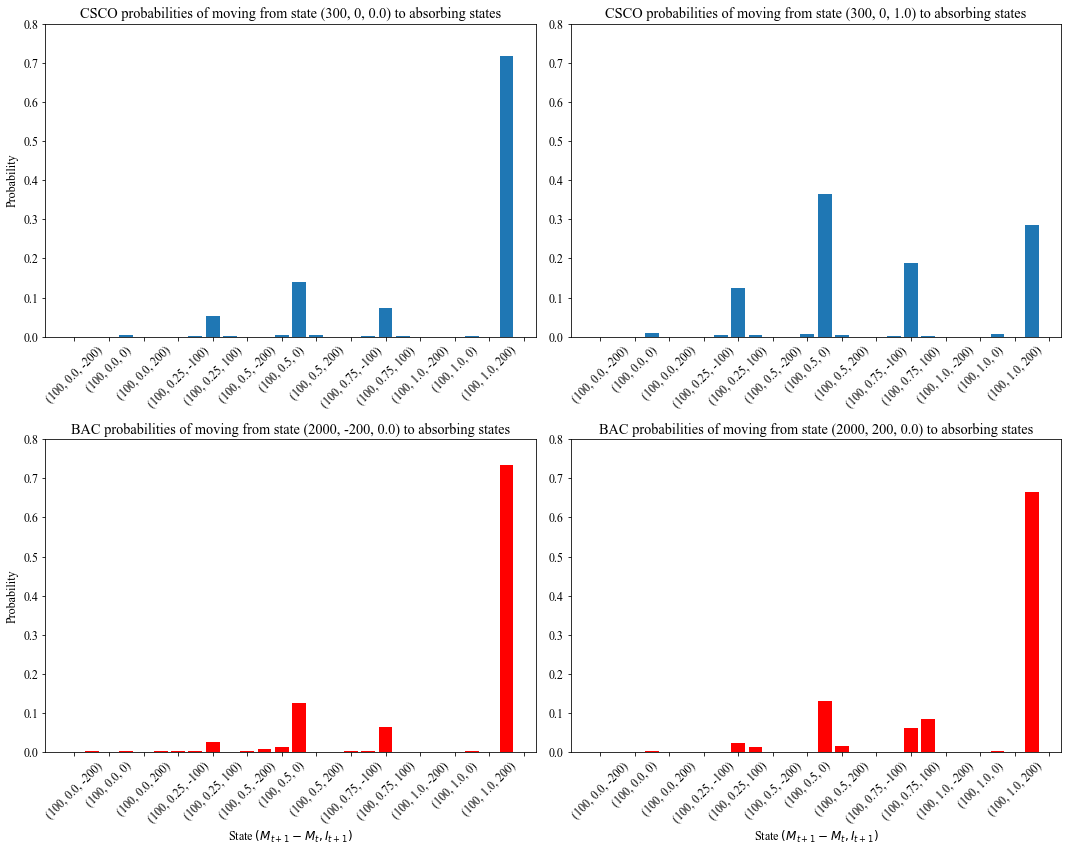

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(15,12))

ax[0, 0].bar(
    [str((x[0], x[1], x[2])) for x in csco_queue_value.absorbing_prob_df.columns.values], 
    np.dot(csco_inv_trans_sum.iloc[20].values, csco_queue_value.absorbing_prob_df.values)
)
ax[0, 0].set_title(
    f"CSCO probabilities of moving from state {csco_inv_trans_sum.iloc[20].name[1:][::-1]} to absorbing states"
)
ax[0, 0].set_ylabel("Probability")
ax[0, 0].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[0, 1].bar(
    [str((x[0], x[1], x[2])) for x in csco_queue_value.absorbing_prob_df.columns.values], 
    np.dot(csco_inv_trans_sum.iloc[220].values, csco_queue_value.absorbing_prob_df.values)
)
ax[0, 1].set_title(
    f"CSCO probabilities of moving from state {csco_inv_trans_sum.iloc[220].name[1:][::-1]} to absorbing states"
)
ax[0, 1].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[1, 0].bar(
    [str((x[0], x[1], x[2])) for x in bac_queue_value.absorbing_prob_df.columns.values], 
    np.dot(bac_inv_trans_sum.iloc[0].values, bac_queue_value.absorbing_prob_df.values),
    color="r"
)
ax[1, 0].set_title(
    f"BAC probabilities of moving from state {bac_inv_trans_sum.iloc[0].name[1:][::-1]} to absorbing states"
)
ax[1, 0].set_ylabel("Probability")
ax[1, 0].xaxis.set_major_locator(plt.MaxNLocator(16))
ax[1, 0].set_xlabel(r"State $(M_{t+1}-M_{t}, I_{t+1})$")

ax[1, 1].bar(
    [str((x[0], x[1], x[2])) for x in bac_queue_value.absorbing_prob_df.columns.values], 
    np.dot(bac_inv_trans_sum.iloc[40].values, bac_queue_value.absorbing_prob_df.values),
    color="r"
)
ax[1, 1].set_title(
    f"BAC probabilities of moving from state {bac_inv_trans_sum.iloc[40].name[1:][::-1]} to absorbing states"
)
ax[1, 1].xaxis.set_major_locator(plt.MaxNLocator(16))
ax[1, 1].set_xlabel(r"State $(M_{t+1}-M_{t}, I_{t+1})$")

plt.setp(ax[0,0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[0,1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1,0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1,1].xaxis.get_majorticklabels(), rotation=45)

ax[0, 0].set_ylim([0, 0.8])
ax[0, 1].set_ylim([0, 0.8])
ax[1, 0].set_ylim([0, 0.8])
ax[1, 1].set_ylim([0, 0.8])

fig.tight_layout()

plt.show()

### Compute order values

In [14]:
csco_order_value_df = csco_queue_value.calculate_order_values(csco_order_values_1)

bac_order_value_df = bac_queue_value.calculate_order_values(bac_order_values_1)

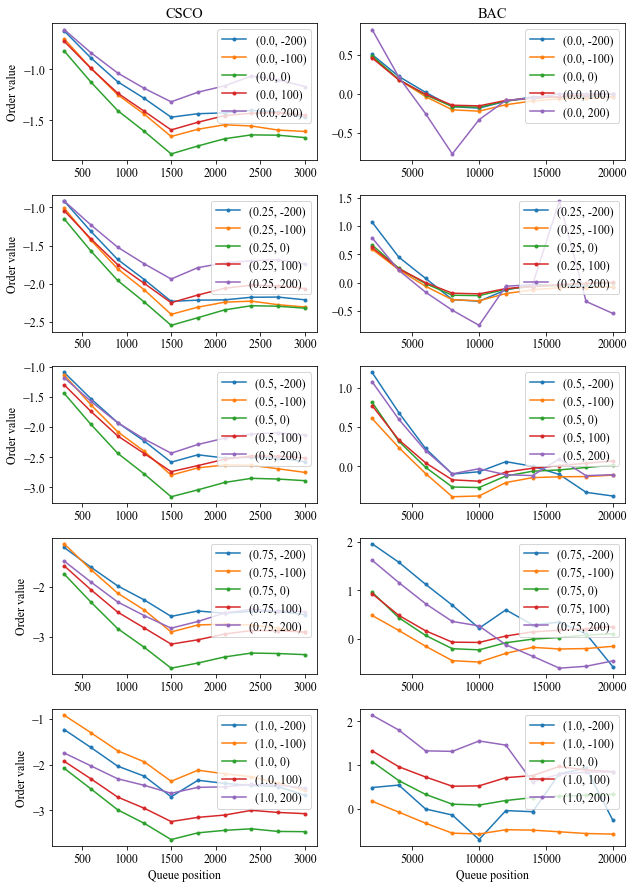

In [15]:
fig, ax = plt.subplots(5, 2, figsize=(9,13))

ax[0, 0].plot(csco_order_value_df.iloc[:, :5], ".-")
ax[0, 0].legend(list(csco_order_value_df.iloc[:, :5].columns), loc="upper right")
ax[0, 0].set_title("CSCO")
ax[0, 0].set_ylabel("Order value")

ax[1, 0].plot(csco_order_value_df.iloc[:, 5:10], ".-")
ax[1, 0].legend(list(csco_order_value_df.iloc[:, 5:10].columns), loc="upper right")
ax[1, 0].set_ylabel("Order value")

ax[2, 0].plot(csco_order_value_df.iloc[:, 10:15], ".-")
ax[2, 0].legend(list(csco_order_value_df.iloc[:, 10:15].columns), loc="upper right")
ax[2, 0].set_ylabel("Order value")

ax[3, 0].plot(csco_order_value_df.iloc[:, 15:20], ".-")
ax[3, 0].legend(list(csco_order_value_df.iloc[:, 15:20].columns), loc="upper right")
ax[3, 0].set_ylabel("Order value")

ax[4, 0].plot(csco_order_value_df.iloc[:, 20:25], ".-")
ax[4, 0].legend(list(csco_order_value_df.iloc[:, 20:25].columns), loc="upper right")
ax[4, 0].set_xlabel("Queue position")
ax[4, 0].set_ylabel("Order value")

ax[0, 1].plot(bac_order_value_df.iloc[:, :5], ".-")
ax[0, 1].legend(list(bac_order_value_df.iloc[:, :5].columns), loc="upper right")
ax[0, 1].set_title("BAC")

ax[1, 1].plot(bac_order_value_df.iloc[:, 5:10], ".-")
ax[1, 1].legend(list(bac_order_value_df.iloc[:, 5:10].columns), loc="upper right")

ax[2, 1].plot(bac_order_value_df.iloc[:, 10:15], ".-")
ax[2, 1].legend(list(bac_order_value_df.iloc[:, 10:15].columns), loc="upper right")

ax[3, 1].plot(bac_order_value_df.iloc[:, 15:20], ".-")
ax[3, 1].legend(list(bac_order_value_df.iloc[:, 15:20].columns), loc="upper right")

ax[4, 1].plot(bac_order_value_df.iloc[:, 20:25], ".-")
ax[4, 1].legend(list(bac_order_value_df.iloc[:, 20:25].columns), loc="upper right")
ax[4, 1].set_xlabel("Queue position")

fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.show()

### Calculate uptick probabilities

In [16]:
up_tick_probs = pd.DataFrame(
    index=bac_inv_trans_sum.index.droplevel(0),
    columns=["prob"]
)
up_tick_prob_dfs = []
for state in up_tick_probs.index:
    up_tick_prob_df = pd.DataFrame(
        columns=[bac_inv_trans_sum.loc[(0.0, state[0], state[1], state[2])].name],
        index=[str((x[0], x[1], x[2])) for x in bac_queue_value.absorbing_prob_df.columns.values],
        data=np.dot(
            bac_inv_trans_sum.loc[(0.0, state[0], state[1], state[2])].values, 
            bac_queue_value.absorbing_prob_df.values
        )
    )
    up_tick_prob_dfs.append(up_tick_prob_df)
    up_tick_probs.loc[state] = up_tick_prob_df.iloc[:-1].sum().iloc[0]  # Exclude final (tick-down) state

### Load in relevant transition matrices under strategy 1

In [17]:
bac_inv_trans_sum_1 = pd.read_csv(
    os.path.join(ROOT_DIR, "models", "bac_inv_trans_sum.csv"), header=[0,1,2,3], index_col=[0,1,2,3]
)
bac_absorbing_probs_1 = pd.read_csv(
    os.path.join(ROOT_DIR, "models", "bac_absorbing_probs.csv"), header=[0,1,2,3], index_col=[0,1,2,3]
)

### Calculate fill probabilities

In [18]:
up_tick_transition_probs = np.dot(
    bac_inv_trans_sum.values, 
    bac_queue_value.absorbing_prob_df.iloc[:, :-1].values
)
post_up_tick_fill_probs = np.dot(
    bac_inv_trans_sum_1.values, 
    bac_absorbing_probs_1.iloc[:,:-1].values
)
fill_probs_2 = pd.DataFrame(
    index=bac_inv_trans_sum.index,
    data=np.dot(up_tick_transition_probs, post_up_tick_fill_probs)
).sum(axis=1)
fill_probs_2 = fill_probs_2.to_frame(name="prob")
fill_probs_2.index = fill_probs_2.index.droplevel([0])

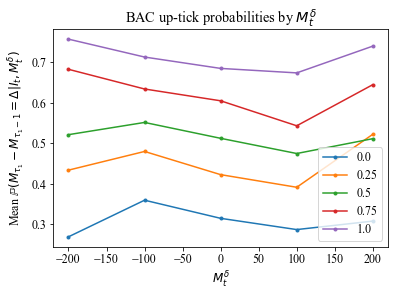

In [19]:
fig, ax = plt.subplots()

for imbalance in bac_orderbooks[0].imbalance_steps:
    # Filter out zeros as they are due to insufficient data
    ax.plot(up_tick_probs[up_tick_probs["prob"] != 0].loc[imbalance].unstack().mean(axis=1), ".-")

ax.legend(list(bac_orderbooks[0].imbalance_steps), loc="lower right")
ax.set_title(r"BAC up-tick probabilities by $M^{\delta}_{t}$")
ax.set_ylabel(r"Mean $\mathbb{P}(M_{\tau_{1}} - M_{\tau_{1} - 1} = \Delta | I_{t}, M^{\delta}_{t})$")
ax.set_xlabel(r"$M^{\delta}_{t}$")

plt.show()

### Load in micro-prices

In [20]:
bac_microprices = pd.read_csv(
    os.path.join(ROOT_DIR, "models", "bac_micro_price.csv"), index_col=[0,1]
)

### Plot order value breakdown

In [21]:
liquidity_premium = 150 - bac_microprices
liquidity_premium = liquidity_premium.rename({"0": "liquidity_premium"}, axis=1)

In [22]:
adverse_selection = -1 * bac_order_value_df.stack().stack().swaplevel(i=- 3, j=- 1).reindex(
    fill_probs_2.index
).divide(fill_probs_2["prob"])

for state in adverse_selection.index:
    adverse_selection.loc[state] += liquidity_premium.loc[(state[0], state[1])].values[0]

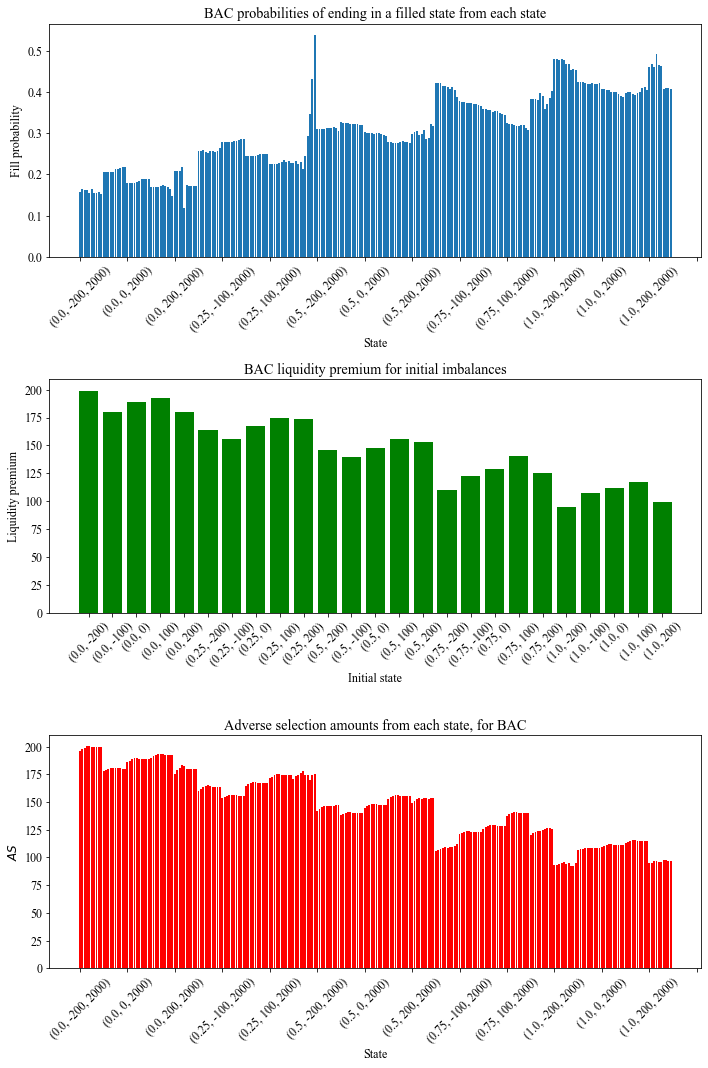

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(10,15))

ax[0].bar(
    [str(state) for state in fill_probs_2.index], 
    fill_probs_2.replace(to_replace=0, method="ffill").values.T[0]
)
ax[0].set_title(f"BAC probabilities of ending in a filled state from each state")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Fill probability")
ax[0].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[1].bar(
    [str(x) for x in liquidity_premium.index],
    liquidity_premium["liquidity_premium"],
    color="g"
)
ax[1].set_title("BAC liquidity premium for initial imbalances")
ax[1].set_xlabel("Initial state")
ax[1].set_ylabel("Liquidity premium")

ax[2].bar(
    [str(state) for state in adverse_selection.index], 
    adverse_selection.replace(
        to_replace=-np.inf, method="ffill"
    ).replace(to_replace=np.inf, method="ffill").fillna(method="ffill").values,
    color="r"
)
ax[2].set_title(f"Adverse selection amounts from each state, for BAC")
ax[2].set_xlabel("State")
ax[2].set_ylabel(r"$AS$")
ax[2].xaxis.set_major_locator(plt.MaxNLocator(16))

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=45)

fig.tight_layout()

plt.show()